## Data dependencies

```
# from colab 10.10-weave-surprisal-Bloom-zh-3b.ipynb
37b7f67f5cc0685e0d223a1fc3f733f2fde70ee6  decode_nll_bloom-zh-3b.pkl  
```

In [1]:
nll_path = "../../data/surprisal/decode_nll_bloom-zh-3b.pkl"
!sha1sum $nll_path

37b7f67f5cc0685e0d223a1fc3f733f2fde70ee6  ../../data/surprisal/decode_nll_bloom-zh-3b.pkl


## Load Data

In [2]:
nll_path = "../../data/surprisal/decode_nll_bloom-zh-3b.pkl"
from pathlib import Path
import pickle

nll_data = pickle.loads(Path(nll_path).read_bytes())

In [3]:
len(nll_data)

55

## Reconstruct sequence NLLs

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from typing import cast, Tuple

In [5]:
tokenizer = AutoTokenizer.from_pretrained("ckip-joint/bloom-3b-zh", add_prefix_space=True)

In [6]:
speakers_out = {}
for speaker_id, seq_data in nll_data.items():
  utt_out = {}
  for seq_x in seq_data:
    utt_start_idx = seq_x["start_idx"]
    utt_end_idx = seq_x["end_idx"]
    words_x = seq_x["sequences"]
    word_seq = sum(words_x, [])

    utt_span = {}   # from utt_idx to (word_start, word_end) in word_seq
    word_cursor = 0
    for i, words in enumerate(words_x):
      utt_span[utt_start_idx+i] = (word_cursor, word_cursor + len(words))
      word_cursor += len(words)
      
    batch = tokenizer(word_seq, 
                      is_split_into_words=True)
    # a map form word (flatten) index to token index
    word_to_token = [batch.word_to_tokens(wi) for wi in range(len(word_seq))]
    nll_x = np.hstack([np.nan, seq_x["nll"]])  # pad a None at first, so the length is the same

    ## fill in utterance NLL
    for utt_idx, word_span in utt_span.items():
      
      if utt_idx in utt_out:
        continue
      
      wsp_start_idx = word_span[0]
      wsp_end_idx = word_span[1]
      # print(word_seq[wsp_start_idx:wsp_end_idx])

      utt_words = []
      utt_nlls = []
      for wi in range(wsp_start_idx, wsp_end_idx):
        tsp = word_to_token[wi] # type: ignore
        word_x = word_seq[wi]
        word_chk = tokenizer.decode(batch["input_ids"][tsp[0]:tsp[1]]) # type: ignore
        assert word_x == word_chk

        word_nll_x = nll_x[tsp[0]:tsp[1]].mean() # type: ignore
        
        if word_x == "\n": continue
        utt_words.append(word_x)
        utt_nlls.append(word_nll_x)

      utt_out[utt_idx] = {"words": utt_words, "nlls": utt_nlls}

  speakers_out[speaker_id] = utt_out

## Export Artifact

In [7]:
import json
speakers_nll_path = Path("../../data/surprisal/20.00-speakers_nll_decoded.json")
speakers_nll_path.write_text(json.dumps(speakers_out, ensure_ascii=False, indent=2))
!sha1sum $speakers_nll_path

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
dbf53d576713af9f8d4e783f64d52500fe30f43c  ../../data/surprisal/20.00-speakers_nll_decoded.json


## Sandboxing

In [8]:
from textwrap import wrap
from io import StringIO
byword_nll = {}
sio = StringIO()
words_series = []
nlls_series = []
smoothValue = None

# sio.write("<div class='wrapper'>")
for xx in utt_out.values():
  words, nlls = xx["words"], xx["nlls"]

  for w, logP in zip(words, nlls):
      words_series.append(w)
      # sio.write(f"<span class='word' nll='{logP:.4f}'>{w}</span>\n")
      sio.write(f"{w}({logP:.4f}) ")
      if np.isnan(logP): continue
      if smoothValue:
        smoothValue = logP*.01+smoothValue*.99
        nlls_series.append(smoothValue)
      else:
        nlls_series.append(logP)
        smoothValue = logP
# sio.write("</div>")  

print("\n".join(wrap(sio.getvalue(), 80)))



喔(nan) 我(7.2188) 平常(7.5312) 講(7.8438) 台語(2.4480) 喔(4.2812) 其實(7.8750) 是(3.1562)
因為(7.2500) 之前(5.5000) 我(3.3125) 小時候(2.2119) 啊(6.1562) hoN(12.5312) 我(4.3750)
a(11.5000) cho(10.7500) 就是(6.2500) 那(6.6875) 個(5.3125) 曾祖母(5.8311) 啊(1.9922)
他(4.6875) 是(10.1875) 跟(6.4062) 我們(1.6562) 住(4.5625) 在(8.6250) 一起(7.7500)
然後(2.9062) 他(2.5469) 從小(5.9062) 就(1.1953) 把(8.4375) 我們(0.7852) 帶(2.8594)
長大(4.0625) 然後(1.9922) 我(2.7969) a(4.0625) cho(0.2285) 他(2.9219) 只(6.5938)
會(3.5156) 講(0.3008) 台語(0.3564) 而已(4.6250) 啊(2.6406) 然後(2.5781) 我(2.1875)
小時候(1.4916) 就(3.3281) 一直(2.9219) 以為(3.9219) 說(4.2500) 就是(4.9062) 就是(5.6875)
人(7.4688) 老(4.4062) 了(8.7500) 之後(3.3281) 就(2.5938) 只(4.8750) 會(1.2266)
變成(8.3750) 只(5.0000) 會(1.0156) 講(0.2158) 台語(0.1262) 而已(2.2500) heN(8.0938)
然後(2.1094) 所以(4.3750) 我(6.6250) 小時候(1.3556) 就(2.5938) 是(11.3750) 跟(4.7812)
a(4.0000) cho(0.2559) 住(3.4844) 在(6.8750) 一起(2.7656) 然後(1.5938) 還(6.5312)
有(9.7500) 我(2.5625) 妹妹(4.7812) 然後(3.9219) 就是(4.0938) 因為(3.4531) 每(7.6250)
天(8.7500) 這樣(7.4375) 相處(3.68

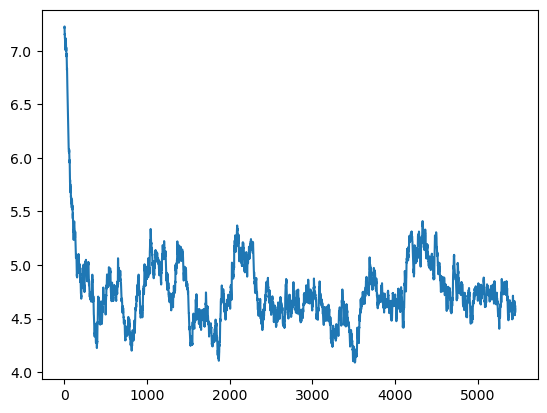

In [9]:
plt.plot(nlls_series)